# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import cv2
import time
import numpy as np
import imageio
import random
import matplotlib.pyplot as plt
from heapq import heappop, heappush
from itertools import permutations

/tmp/ipykernel_1303537/1205922353.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_1303537/1205922353.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 853737
Free Cells: 146263


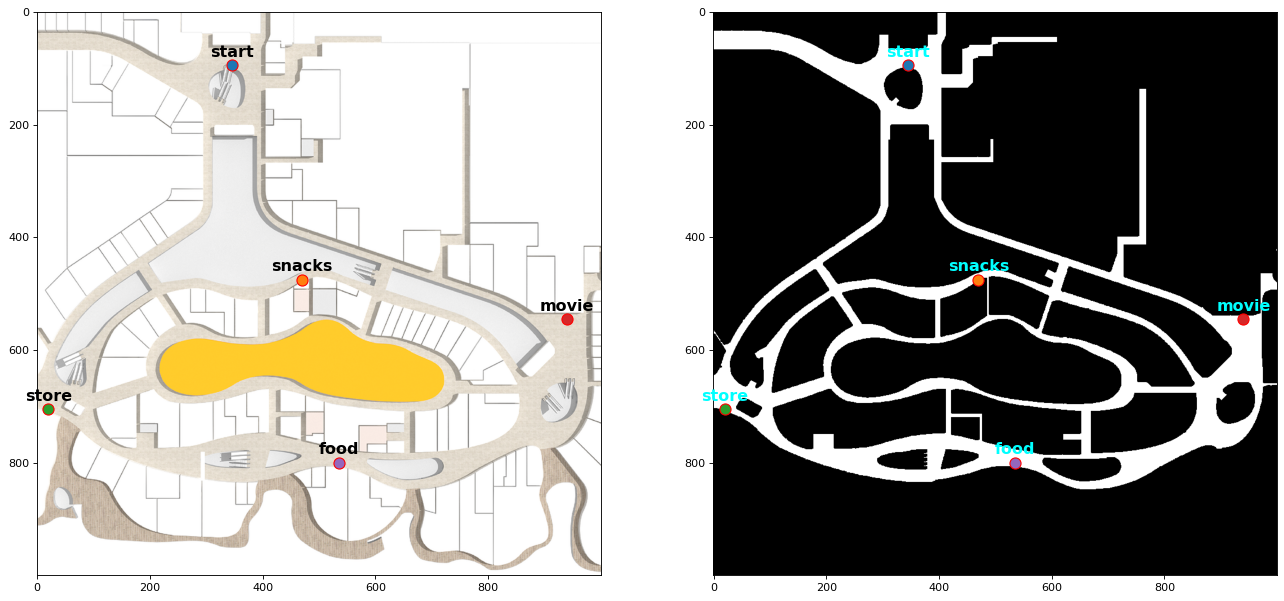

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality
ROB_RAD = 0.3 # Robot's radius is 0.3m
kernel_size = int(np.ceil(ROB_RAD / MAP_RES)) # Convert to grid cells
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size * 2, kernel_size * 2))
cspace_map = cv2.dilate((grid_map_img == 0).astype(np.uint8), kernel, iterations=1)  # Expand obstacles
cspace_map = (1 - cspace_map) * 255  # Convert back to free space format
grid_map = cspace_map.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

keys = ['start', 'snacks', 'store', 'movie', 'food']

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str' = 'black'):
    for key, value in locations.items():
        plt.plot(value[0], value[1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(value[0], value[1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(cspace_map, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1 & 2

#### Implement an A* planning algorithm

In [3]:
# Define heuristic function using euclidean distance
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

# Run the A* algorithm from start to goal 
def a_star_search(grid_map, start, goal):
    rows, cols = grid_map.shape
    open_set = []
    heappush(open_set, (0, tuple(start)))
    came_from = {}
    g_score = {tuple(start): 0}
    f_score = {tuple(start): heuristic(start, goal)}
    visited_cells = set()  # Store all visited cells

    # 8-connected neighbors, with cost values 0.2m or 0.282m
    directions = [
        (-1, 0, 0.2), (1, 0, 0.2),  # left, right
        (0, -1, 0.2), (0, 1, 0.2),  # up, dowm
        (-1, -1, 0.282), (-1, 1, 0.282), # lower left, lower right
        (1, -1, 0.282), (1, 1, 0.282)   # top left, top right
    ]
    
    while open_set:
        _, current = heappop(open_set)
        visited_cells.add(current)

        if current == tuple(goal):
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(tuple(start))
            path.reverse()
            return path, visited_cells
        
        for dx, dy, move_cost in directions:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid_map[neighbor] == 255:
                tentative_g_score = g_score[current] + move_cost
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heappush(open_set, (f_score[neighbor], neighbor))
    return [], visited_cells  # Return empty path if no solution

# Calculate the euclidean distance between two positions
def euclidean_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

# Calculate the euclidean distance of the path from start to goal
def compute_path_distance(path):
    return sum(euclidean_distance(path[i], path[i-1]) for i in range(1, len(path))) * MAP_RES

# Calculate the shortest distances between each pair of locations using A*
def run_a_star(grid_map, locations, keys):
    start_time = time.perf_counter()
    path_cache = {}
    path_cache_dist = {}
    all_visited_cells = set()
    
    for i in range(len(keys)):
        for j in range(len(keys)):
            if i != j:
                start, goal = locations[keys[i]], locations[keys[j]]
                path, visited_cells = a_star_search(grid_map, start, goal)
                path_cache[(keys[i], keys[j])] = path
                path_cache_dist[(keys[i], keys[j])] = compute_path_distance(path)
                all_visited_cells.update(visited_cells)
            else:
                path_cache_dist[(keys[i], keys[j])] = 0
    
    end_time = time.perf_counter()
    a_star_execution_time = end_time - start_time
    return path_cache, path_cache_dist, all_visited_cells, a_star_execution_time

#### Try different Travelling Shopper Problem (TSP) algorithms

In [4]:
# Solve Travelling Shopper Problem (TSP) through trying all possible orderings of the locations
def tsp_exhaustive_search(path_cache_dist, keys):
    start_time = time.perf_counter()
    shortest_distance = float('inf')
    best_route = []
    
    for perm in permutations(keys[1:]):
        route = ['start'] + list(perm) + ['start']
        total_distance = sum(path_cache_dist[(route[i], route[i+1])] for i in range(len(route) - 1))
        if total_distance < shortest_distance:
            shortest_distance = total_distance
            best_route = route
    
    end_time = time.perf_counter()
    tsp_execution_time = end_time - start_time
    return best_route, shortest_distance, tsp_execution_time

# Solve Travelling Shopper Problem (TSP) through taking the nearest neighbor from current
def tsp_nearest_neighbor(path_cache_dist, keys):
    start_time = time.perf_counter()
    unvisited = set(keys)
    unvisited.remove('start')
    best_route = ['start']
    shortest_distance = 0
    current = 'start'

    while unvisited:
        next = min(unvisited, key=lambda pos: path_cache_dist[(current, pos)])
        shortest_distance += path_cache_dist[(current, next)]
        best_route.append(next)
        unvisited.remove(next)
        current = next

    shortest_distance += path_cache_dist[(current, 'start')]
    best_route.append('start')

    end_time = time.perf_counter()
    tsp_execution_time = end_time - start_time
    return best_route, shortest_distance, tsp_execution_time

#### Visualization results

In [5]:
def plot_distance_table(path_cache_dist, keys):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('tight')
    ax.axis('off')

    table_data = [[""] + keys]
    for k1 in keys:
        row = [k1] + [f"{path_cache_dist[(k2, k1)]:.1f}" for k2 in keys]
        table_data.append(row)

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 3.0)
    for i in range(1, len(keys) + 1):
        table[i, i].set_facecolor("lightgrey")
    plt.show()

def plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route):
    plt.figure(figsize=(20, 10), dpi=80)
    plt.subplot(1,2,1)
    plt.imshow(floor_plan)
    all_visited_cells = np.array(list(all_visited_cells))
    plt.plot(all_visited_cells[:, 0], all_visited_cells[:, 1], 'b.', markersize=1)
    plot_locations(locations)
    plt.subplot(1,2,2)
    plt.imshow(grid_map.transpose(), cmap='gray')
    all_visited_cells = np.array(list(all_visited_cells))
    plt.plot(all_visited_cells[:, 0], all_visited_cells[:, 1], 'b.', markersize=1)
    plot_locations(locations, color='cyan')
    for i in range(len(best_route) - 1):
        path = path_cache[(best_route[i], best_route[i+1])]
        if path:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'r-', linewidth=2)
    plt.show()

A* algorithm execution time: 3.7336 seconds
Number of visited cells: 42700


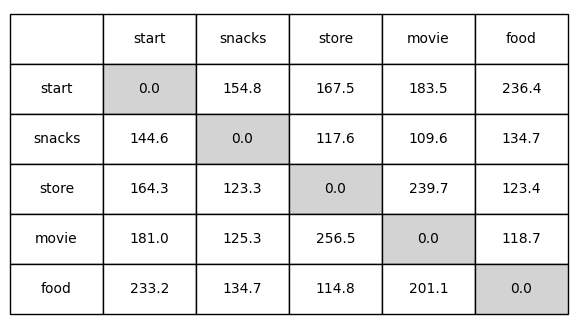

------------Exhaustive Search TSP------------
Best Route : ['start', 'store', 'food', 'movie', 'snacks', 'start']
Total Distance: 662.27 meters
TSP algorithm execution time: 0.0000 seconds


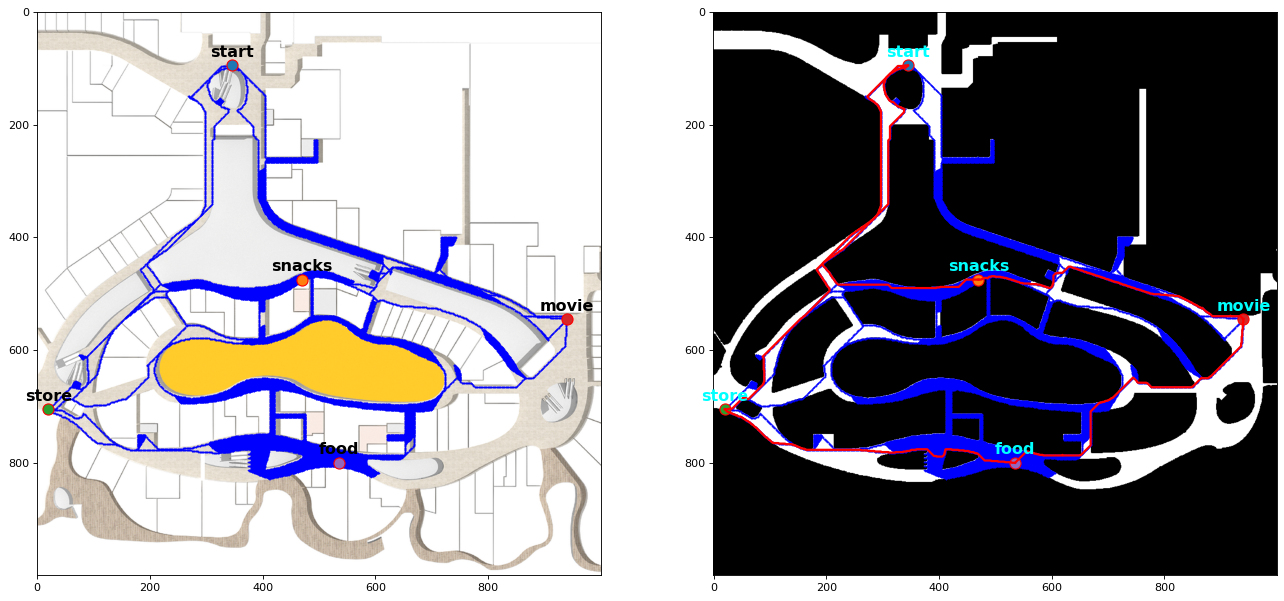

------------Nearest Neighbor TSP------------
Best Route : ['start', 'snacks', 'store', 'food', 'movie', 'start']
Total Distance: 684.94 meters
TSP algorithm execution time: 0.0000 seconds


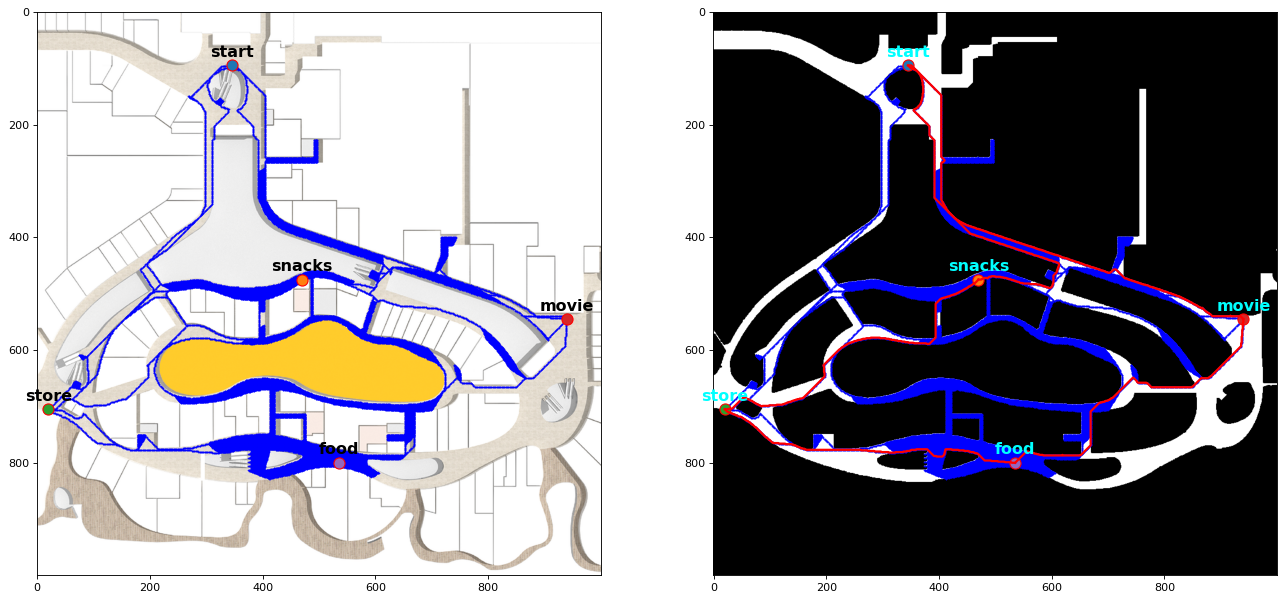

In [6]:
path_cache, path_cache_dist, all_visited_cells, a_star_execution_time \
      = run_a_star(grid_map, locations, keys)
print(f'A* algorithm execution time: {a_star_execution_time:.4f} seconds')
print(f'Number of visited cells: {len(all_visited_cells)}')
plot_distance_table(path_cache_dist, keys)
best_route_tsp1, shortest_distance_tsp1, execution_time_tsp1 \
      = tsp_exhaustive_search(path_cache_dist, keys)
best_route_tsp2, shortest_distance_tsp2, execution_time_tsp2 \
      = tsp_nearest_neighbor(path_cache_dist, keys)
print(f'------------Exhaustive Search TSP------------')
print(f'Best Route : {best_route_tsp1}')
print(f'Total Distance: {shortest_distance_tsp1:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp1:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp1)
print(f'------------Nearest Neighbor TSP------------')
print(f'Best Route : {best_route_tsp2}')
print(f'Total Distance: {shortest_distance_tsp2:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp2:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp2)

#### Try different heuristic functions

In [7]:
# Define heuristic function using Manhattan Distance
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

A* algorithm execution time: 7.9803 seconds
Number of visited cells: 53691


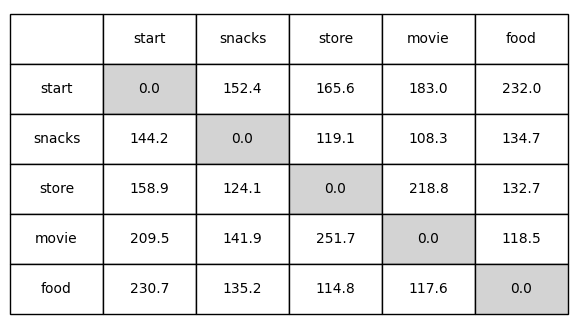

------------Exhaustive Search TSP------------
Best Route : ['start', 'store', 'food', 'movie', 'snacks', 'start']
Total Distance: 652.91 meters
TSP algorithm execution time: 0.0000 seconds


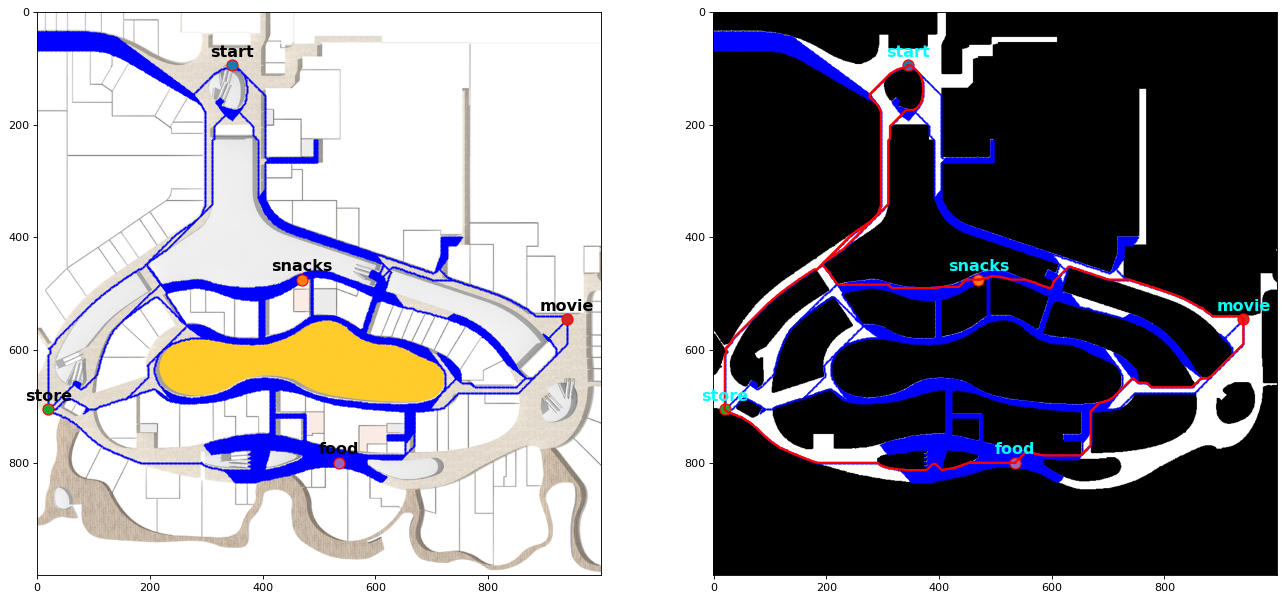

------------Nearest Neighbor TSP------------
Best Route : ['start', 'snacks', 'store', 'food', 'movie', 'start']
Total Distance: 684.57 meters
TSP algorithm execution time: 0.0000 seconds


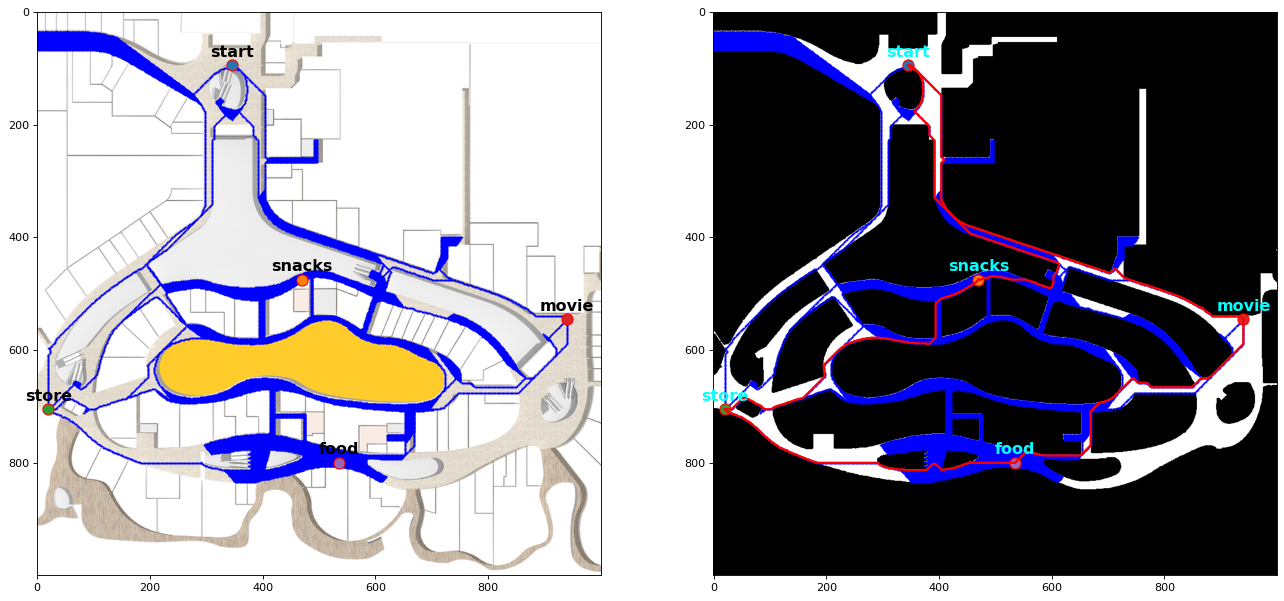

In [8]:
path_cache, path_cache_dist, all_visited_cells, a_star_execution_time \
      = run_a_star(grid_map, locations, keys)
print(f'A* algorithm execution time: {a_star_execution_time:.4f} seconds')
print(f'Number of visited cells: {len(all_visited_cells)}')
plot_distance_table(path_cache_dist, keys)
best_route_tsp1, shortest_distance_tsp1, execution_time_tsp1 \
      = tsp_exhaustive_search(path_cache_dist, keys)
best_route_tsp2, shortest_distance_tsp2, execution_time_tsp2 \
      = tsp_nearest_neighbor(path_cache_dist, keys)
print(f'------------Exhaustive Search TSP------------')
print(f'Best Route : {best_route_tsp1}')
print(f'Total Distance: {shortest_distance_tsp1:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp1:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp1)
print(f'------------Nearest Neighbor TSP------------')
print(f'Best Route : {best_route_tsp2}')
print(f'Total Distance: {shortest_distance_tsp2:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp2:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp2)

In [9]:
# Define heuristic function using Chebyshev Distance
def heuristic(a, b):
    return max(abs(a[0] - b[0]), abs(a[1] - b[1]))

A* algorithm execution time: 12.2235 seconds
Number of visited cells: 62536


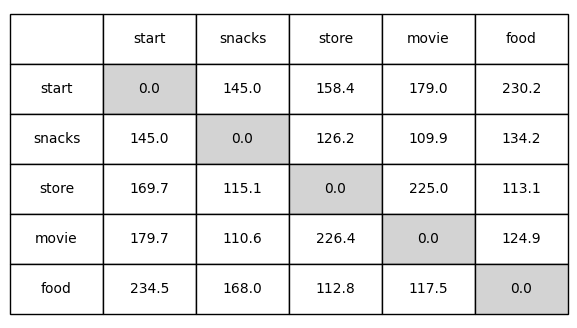

------------Exhaustive Search TSP------------
Best Route : ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 644.67 meters
TSP algorithm execution time: 0.0000 seconds


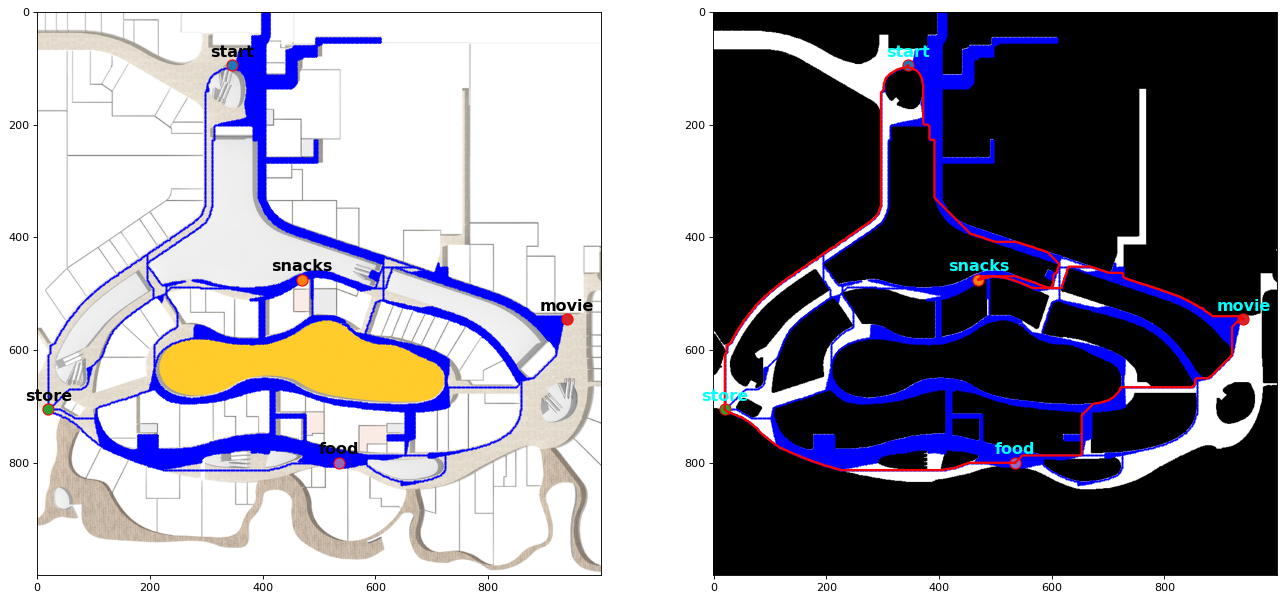

------------Nearest Neighbor TSP------------
Best Route : ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 644.67 meters
TSP algorithm execution time: 0.0000 seconds


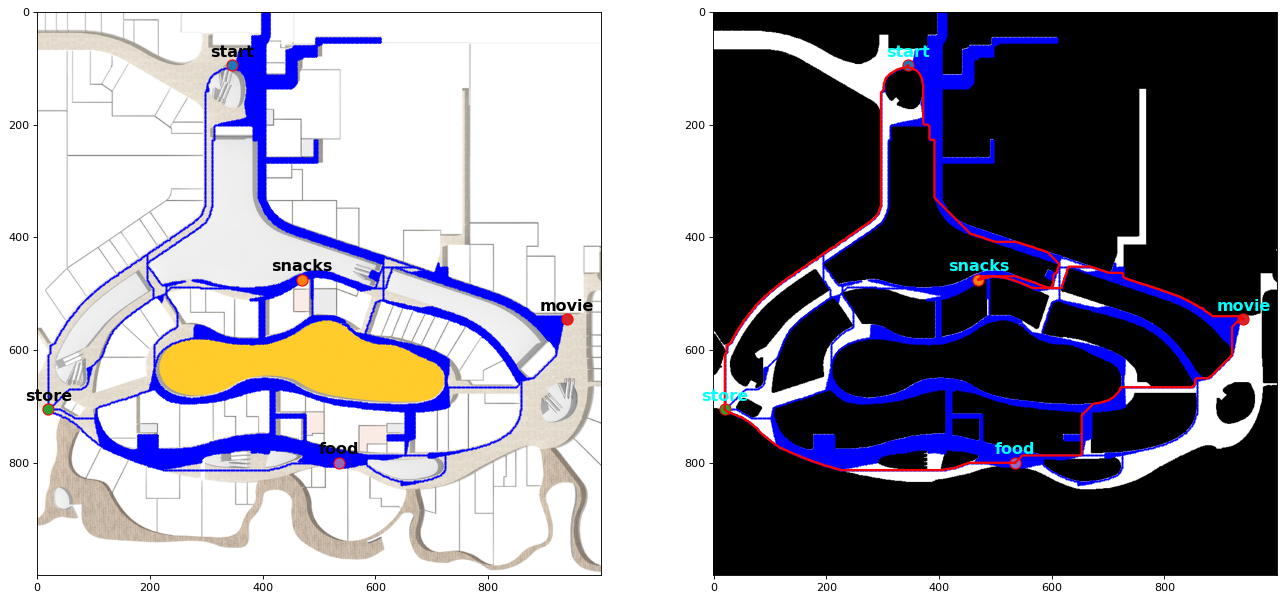

In [10]:
path_cache, path_cache_dist, all_visited_cells, a_star_execution_time \
      = run_a_star(grid_map, locations, keys)
print(f'A* algorithm execution time: {a_star_execution_time:.4f} seconds')
print(f'Number of visited cells: {len(all_visited_cells)}')
plot_distance_table(path_cache_dist, keys)
best_route_tsp1, shortest_distance_tsp1, execution_time_tsp1 \
      = tsp_exhaustive_search(path_cache_dist, keys)
best_route_tsp2, shortest_distance_tsp2, execution_time_tsp2 \
      = tsp_nearest_neighbor(path_cache_dist, keys)
print(f'------------Exhaustive Search TSP------------')
print(f'Best Route : {best_route_tsp1}')
print(f'Total Distance: {shortest_distance_tsp1:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp1:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp1)
print(f'------------Nearest Neighbor TSP------------')
print(f'Best Route : {best_route_tsp2}')
print(f'Total Distance: {shortest_distance_tsp2:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp2:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp2)

In [11]:
# Define heuristic function using Diagonal Distance (for 8-connected grid)
def heuristic(a, b):
    D, D2 = 0.2, 0.282
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    return D * (dx + dy) + (D2 - 2 * D) * min(dx, dy)

A* algorithm execution time: 8.1011 seconds
Number of visited cells: 128457


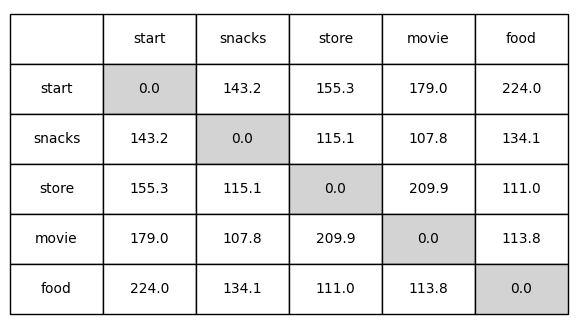

------------Exhaustive Search TSP------------
Best Route : ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 631.09 meters
TSP algorithm execution time: 0.0000 seconds


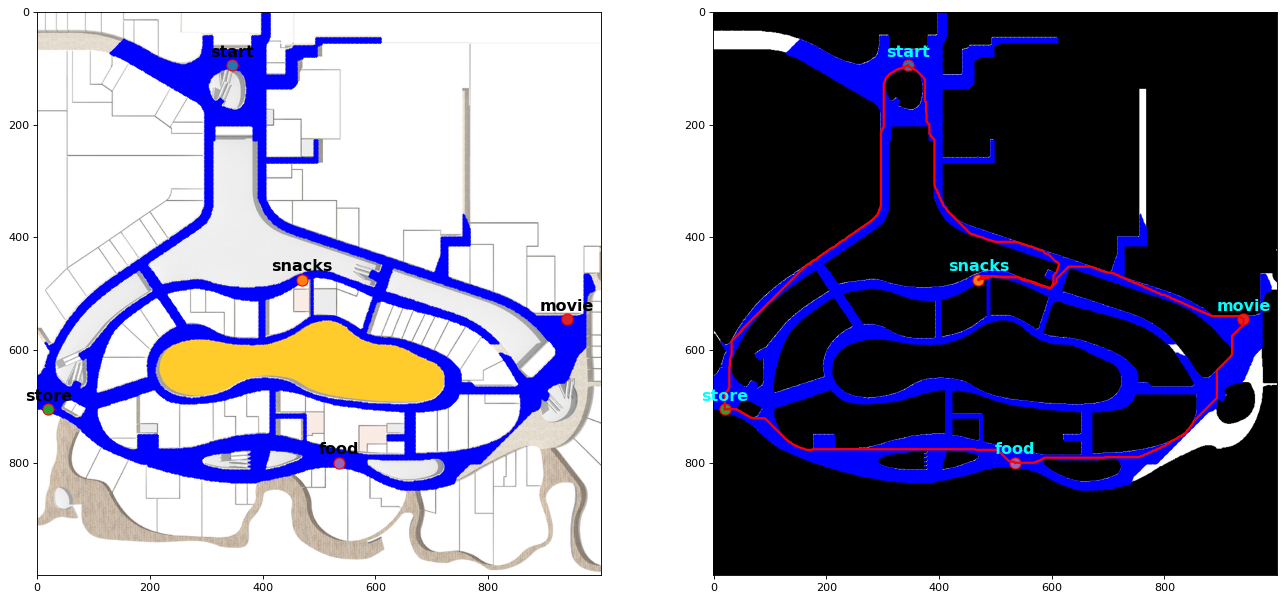

------------Nearest Neighbor TSP------------
Best Route : ['start', 'snacks', 'movie', 'food', 'store', 'start']
Total Distance: 631.09 meters
TSP algorithm execution time: 0.0000 seconds


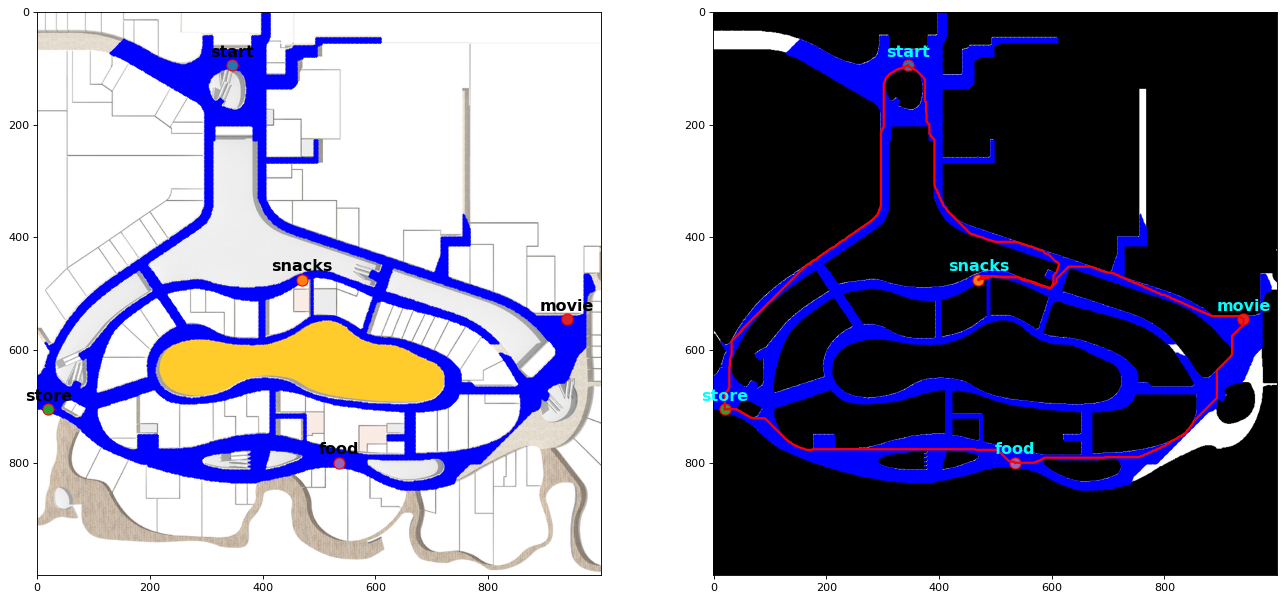

In [12]:
path_cache, path_cache_dist, all_visited_cells, a_star_execution_time \
      = run_a_star(grid_map, locations, keys)
print(f'A* algorithm execution time: {a_star_execution_time:.4f} seconds')
print(f'Number of visited cells: {len(all_visited_cells)}')
plot_distance_table(path_cache_dist, keys)
best_route_tsp1, shortest_distance_tsp1, execution_time_tsp1 \
      = tsp_exhaustive_search(path_cache_dist, keys)
best_route_tsp2, shortest_distance_tsp2, execution_time_tsp2 \
      = tsp_nearest_neighbor(path_cache_dist, keys)
print(f'------------Exhaustive Search TSP------------')
print(f'Best Route : {best_route_tsp1}')
print(f'Total Distance: {shortest_distance_tsp1:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp1:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp1)
print(f'------------Nearest Neighbor TSP------------')
print(f'Best Route : {best_route_tsp2}')
print(f'Total Distance: {shortest_distance_tsp2:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp2:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp2)

#### Implement the RRT family

In [13]:
# RRT Parameters
step_size = 20  # Pixels per step
max_iterations = 200000

class Node:
    def __init__(self, pos, parent=None):
        self.pos = pos
        self.parent = parent

# Generate a random free space point
def get_random_point(grid_map):
    while True:
        pos = (random.randint(0, 999), random.randint(0, 999))
        if grid_map[pos] == 255:
            return pos

# Find nearest node in the tree
def get_nearest_node(tree, point):
    return min(tree, key=lambda node: euclidean_distance(node.pos, point))

# Steer from one node to a new point with a limited step size
def steer(from_node, to_point, step_size):
    vector = np.array(to_point) - np.array(from_node.pos)
    dist = np.linalg.norm(vector)
    if dist < step_size:
        new_point = to_point
    else:
        new_point = tuple((np.array(from_node.pos) + vector / dist * step_size).astype(int))
    return new_point

# Check if the path from from_node to to_point is collision-free
def check_collision(grid_map, from_node, to_point):
    line = np.linspace(from_node.pos, to_point, num=20).astype(int)
    return all(grid_map[tuple(pos)] == 255 for pos in line)

# Run the RRT algorithm from start to goal
def rrt_search(grid_map, start, goal):
    visited_cells = set()
    path = []
    tree = [Node(tuple(start))]
    for _ in range(max_iterations):
        rand_point = tuple(goal) if random.random() < 0.1 else get_random_point(grid_map)
        nearest_node = get_nearest_node(tree, rand_point)
        new_point = steer(nearest_node, rand_point, step_size)
        
        if grid_map[new_point] == 255 and check_collision(grid_map, nearest_node, new_point):
            visited_cells.add(new_point)
            node = Node(new_point, nearest_node)
            tree.append(node)
            if euclidean_distance(new_point, tuple(goal)) < step_size:
                path.append(tuple(goal))
                while node:
                    path.append(node.pos)
                    node = node.parent
                path.append(tuple(start))
                path.reverse()
                return path, visited_cells
    return [], visited_cells

# Calculate the shortest distances between each pair of locations using RRT
def run_rrt(grid_map, locations, keys):
    start_time = time.perf_counter()
    path_cache = {}
    path_cache_dist = {}
    all_visited_cells = set()
    
    for i in range(len(keys)):
        for j in range(len(keys)):
            if i != j:
                start, goal = locations[keys[i]], locations[keys[j]]
                path, visited_cells = rrt_search(grid_map, start, goal)
                path_cache[(keys[i], keys[j])] = path
                path_cache_dist[(keys[i], keys[j])] = compute_path_distance(path)
                all_visited_cells.update(visited_cells)
            else:
                path_cache_dist[(keys[i], keys[j])] = 0
    
    end_time = time.perf_counter()
    rrt_execution_time = end_time - start_time
    return path_cache, path_cache_dist, all_visited_cells, rrt_execution_time

RRT algorithm execution time: 11.3980 seconds
Number of visited cells: 8095


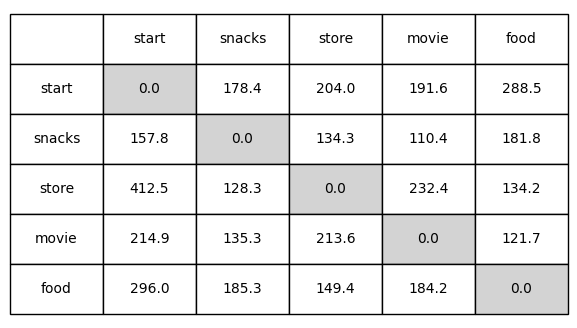

------------Exhaustive Search TSP------------
Best Route : ['start', 'snacks', 'store', 'food', 'movie', 'start']
Total Distance: 748.74 meters
TSP algorithm execution time: 0.0000 seconds


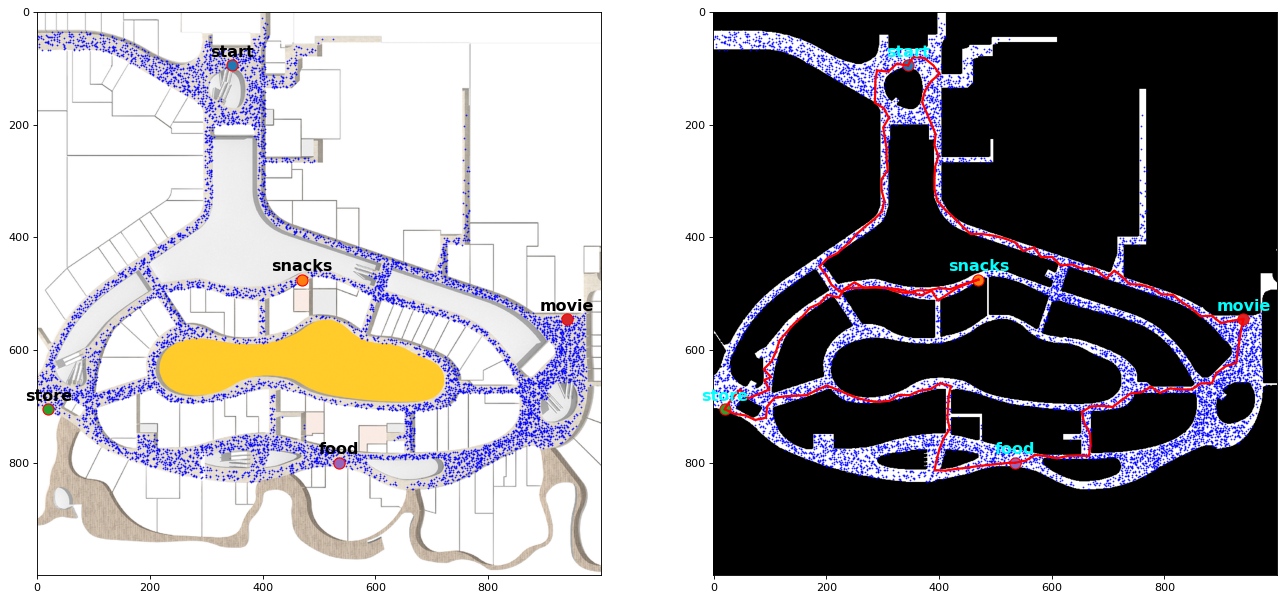

------------Nearest Neighbor TSP------------
Best Route : ['start', 'snacks', 'store', 'food', 'movie', 'start']
Total Distance: 748.74 meters
TSP algorithm execution time: 0.0000 seconds


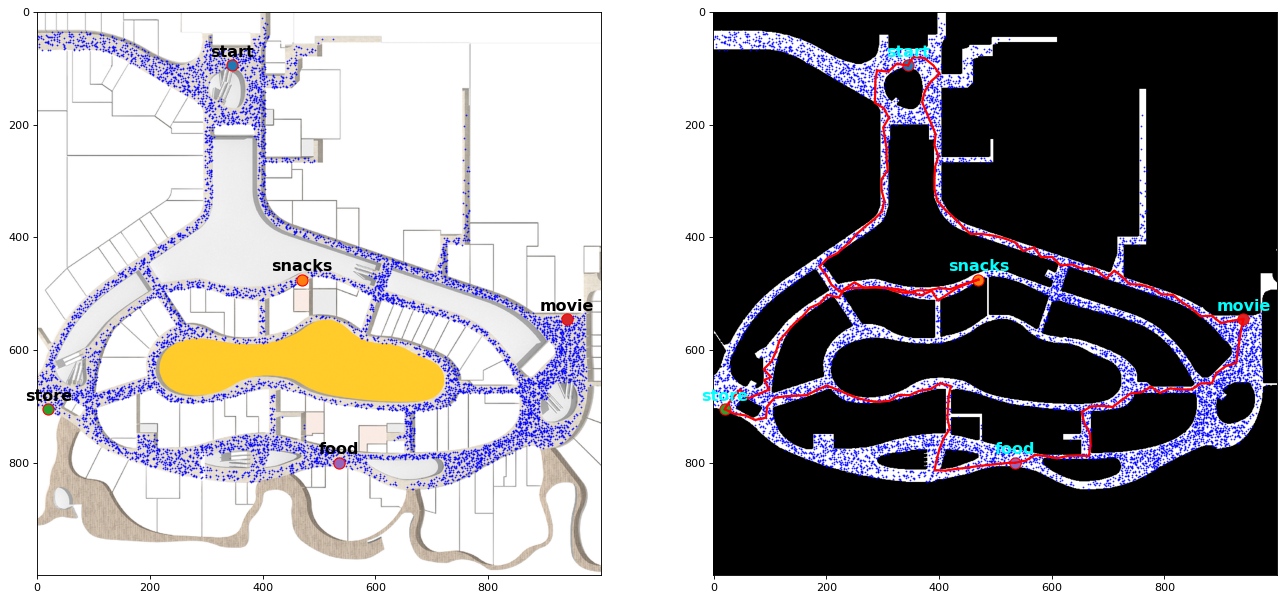

In [14]:
path_cache, path_cache_dist, all_visited_cells, rrt_execution_time \
      = run_rrt(grid_map, locations, keys)
print(f'RRT algorithm execution time: {rrt_execution_time:.4f} seconds')
print(f'Number of visited cells: {len(all_visited_cells)}')
plot_distance_table(path_cache_dist, keys)
best_route_tsp1, shortest_distance_tsp1, execution_time_tsp1 \
      = tsp_exhaustive_search(path_cache_dist, keys)
best_route_tsp2, shortest_distance_tsp2, execution_time_tsp2 \
      = tsp_nearest_neighbor(path_cache_dist, keys)
print(f'------------Exhaustive Search TSP------------')
print(f'Best Route : {best_route_tsp1}')
print(f'Total Distance: {shortest_distance_tsp1:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp1:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp1)
print(f'------------Nearest Neighbor TSP------------')
print(f'Best Route : {best_route_tsp2}')
print(f'Total Distance: {shortest_distance_tsp2:.2f} meters')
print(f'TSP algorithm execution time: {execution_time_tsp2:.4f} seconds')
plot_paths(grid_map, locations, path_cache, all_visited_cells, best_route_tsp2)

## Task 3

In [ ]:
https://github.com/nihaozhan/ME5413_Homework3_planning